# <center> French to English Translation Using <br/> Sequence-to-Sequence RNNs with Attention </center> <a class='tocSkip'>
MSDS 2023 Term 4 ML3 | **Maria Loraine R. Menorca**
    
**Objectives:**

1. Describe what neural machine translation is and how it is done using a sequence-to-sequence RNN with attention.
2. Describe the dataset being used in this example.
3. Describe the preprocessing steps being done in preparation for training the model.
4. Describe the postprocessing code/functions that have been created for performing inference and analyzing the model weights.
5. Compare and contrast the DecoderRNN and AttnDecoderRNN models in terms of loss, training time, parameter count, and quality of translation (qualitatively).
6. In the AttnDecoderRNN model, swap out the GRU for an LSTM. Compare and contrast the two models in terms of loss, training time, parameter count, and quality of translation.
7. Using the best model you’ve found, perform translation on some samples (4 at least) and compare the results with Google Translate. No need to quantitatively evaluate this comparison.
8. Plot the attention weights for the samples you chose and describe the results.


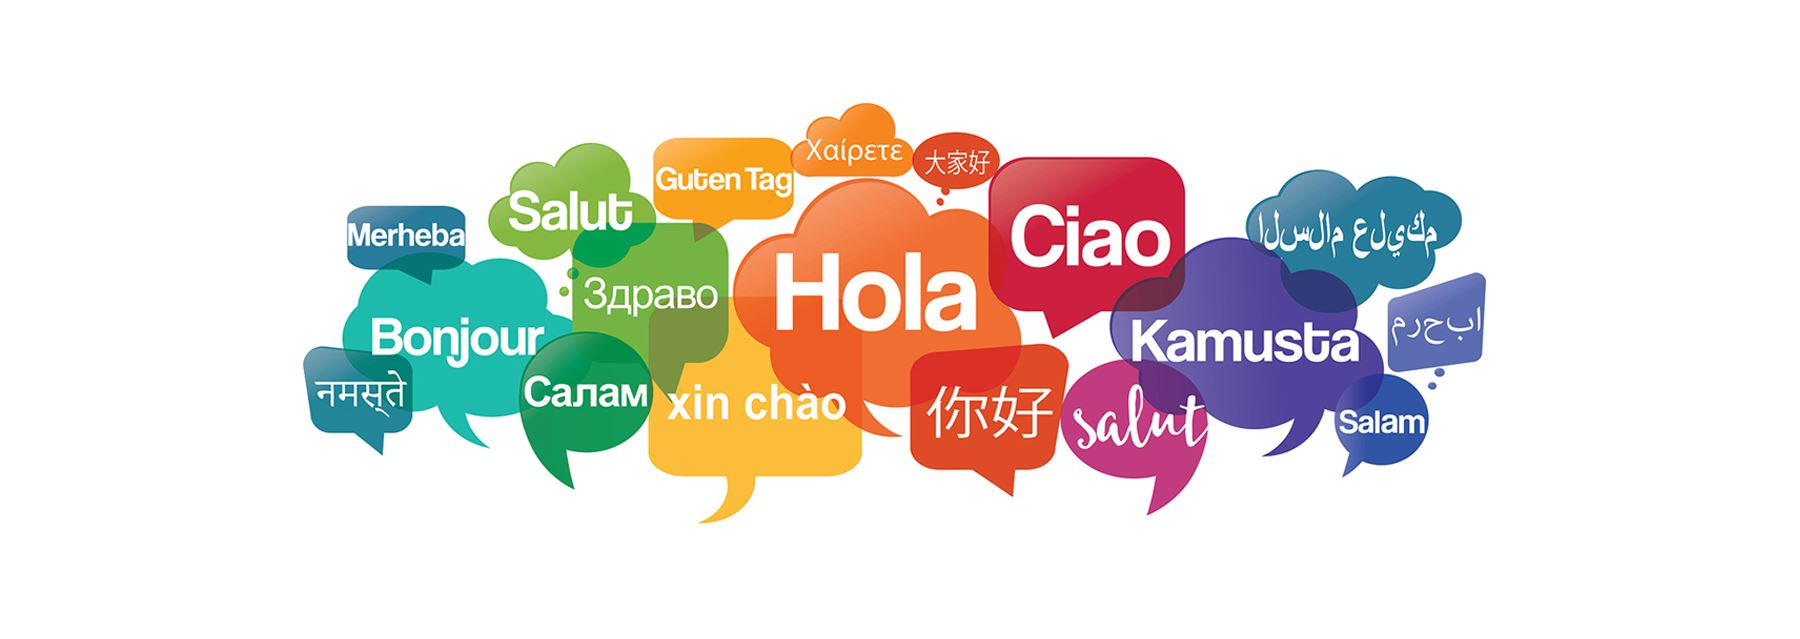

In [1]:
# Helper libraries
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import numpy as np

# For Neural Networks
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# For plotting
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kil2n1d3 because the default path (/home/mmenorca/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Running on: cuda


In [2]:
# import zipfile
# with zipfile.ZipFile('data/names.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/')

# I. Introduction

Neural machine translation is an approach that utilizes neural networks to transform a sequence of words from a source language, such as English, into a desired target language, such as French. More formally, neural machine translation involves finding the target sentence, denoted as $y$, that maximizes the conditional probability of $y$ given the occurrence of a source sentence, denoted as $x$ [1].

One approach for tackling this task is the sequence-to-sequence (*Seq2Seq*) framework [2], which is based on Recurrent Neural Networks (RNNs). In this framework, the RNN model processes an input sequence token by token and generates the output tokens in a similar sequential fashion.

The Seq2Seq [3] architecture is composed of two main components: an encoder and a decoder. The encoder RNN reads the input sequence, typically in an autoregressive manner, and summarizes the information into a fixed-length vector called the "*context vector*". This context vector serves as the initial hidden state of the decoder RNN.

The context, which the decoder uses as a basis for the output sequence, relies heavily on the final hidden state of the encoder, making it challenging for the model to handle long input sequences. To overcome this challenge, an attention mechanism [1] is incorporated to the decoder which enables the model to consider the relevancce of each hidden state in relation to previous states when determining the subsequent state and generating the context. Consequently, the encoder is relieved of the burden of encoding information from the source sequence.

# II. About the data

As an example, data on thousands of English-French translation pairs derived from the [`Tatoeba Project`](https://www.manythings.org/anki/) was used.

The dataset, `eng-fra.txt`, is a tab-delimited file consisting of 135,842 sentence pairs initially. This was reduced to 9,924 pairs with 4,165 French, and 2,661 English words, respectively.

In [3]:
lines = open('data/eng-fra.txt', encoding='utf-8').read().strip().split('\n')
print(f'Total pairs: {len(lines)}')

lines[:10]

Total pairs: 135842


['Go.\tVa !',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!',
 'Wow!\tÇa alors\u202f!',
 'Fire!\tAu feu !',
 "Help!\tÀ l'aide\u202f!",
 'Jump.\tSaute.',
 'Stop!\tÇa suffit\u202f!',
 'Stop!\tStop\u202f!',
 'Stop!\tArrête-toi !']

# III. Data Preprocessing

## Vectorization

The words in a langugage were converted into numbers by representing each as either 1 or 0 (i.e., One-Hot vector). 1 indicates presence of the word in a text and 0 otherwise.

The class Lang can be used to link a word to an index (word2index), an index to word (index2word), and determine the count of each word (word2count).

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    """
    Language class for storing word-to-index and index-to-word mappings.

    Parameters
    ----------
    name : str
        Name of the language.

    Attributes
    ----------
    name : str
        Name of the language.
    word2index : dict
        Dictionary mapping words to their corresponding indices.
    word2count : dict
        Dictionary storing the count of each word.
    index2word : dict
        Dictionary mapping indices to their corresponding words.
    n_words : int
        Total number of words in the language, including SOS and EOS tokens.

    Methods
    -------
    addSentence(sentence)
        Add a sentence to the language by adding each word to the vocabulary.
    addWord(word)
        Add a word to the language's vocabulary.
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2 # Count SOS and EOS
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Normalization

To handle potential inconsistencies in the Unicode files, the data was processed by converting Unicode characters to ASCII, transforming the text to lowercase, and removing most of the punctuation marks.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """
    Convert a Unicode string to its ASCII representation.

    Parameters
    ----------
    s : str
        Input string.

    Returns
    -------
    str
        ASCII representation of the input string.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    """
    Normalize a string by lowercasing, trimming, and removing
    non-letter characters.

    Parameters
    ----------
    s : str
        Input string.

    Returns
    -------
    str
        Normalized string.
    """
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

The data from the file was intially split into lines, the divided into pairs. Each pair consists of an English word and its corresponding translation in another language. To get the reverse word order in the pairs, a reverse flag was added.

In [6]:
def readLangs(lang1, lang2, reverse=False):
    """
    Read language data from a file and preprocess it.

    Parameters
    ----------
    lang1 : str
        Name of the first language.
    lang2 : str
        Name of the second language.
    reverse : bool, optional
        Flag indicating whether to reverse the language pairs
        (default is False).

    Returns
    -------
    input_lang : Lang
        Language instance representing the input language.
    output_lang : Lang
        Language instance representing the output language.
    pairs : list
        List of language pairs, where each pair consists of 
        preprocessed sentences.
    """
    print('Reading lines...')
    
    # Read the file and split into lines
    lines = (open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8')
                .read().strip().split('\n'))
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

## Word-Translation pairings

For illustrative purposes, we focus on short and simple sentences with a maximum length of 10 words, including the ending punctuation. Specifically, sentences that translate to the form "I am" or "He is", etc. are used.

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Gets pairs whose length is within the MAX_LENGTH parameter
def filterPair(p):
    """
    Return pairs of sentences whose character length is within
    the MAX_LENGTH parameter and whose second word starts with an
    english prefix.
    
    Parameters
    ----------
    p : tuple
        Pair of sentences, where the first element is the source sentence
        and the second element is the target sentence.

    Returns
    -------
    bool
        True if the pair satisfies the filtering criteria, False otherwise.
    """
    return (len(p[0].split(' ')) < MAX_LENGTH
            and len(p[1].split(' ')) < MAX_LENGTH
            and p[1].startswith(eng_prefixes))

def filterPairs(pairs):
    """
    Filter a list of sentence pairs based on certain criteria.

    Parameters
    ----------
    pairs : list
        List of sentence pairs, where each pair consists of a source sentence
        and a target sentence.

    Returns
    -------
    list
        Filtered list of sentence pairs that satisfy the filtering criteria.

    """
    return [pair for pair in pairs if filterPair(pair)]

In summary, the data preparation process involves vectorization of words into binary values, text normalization through length and content filtering, and defining word-translation pairings.

In [8]:
def prepareData(lang1, lang2, reverse=False):
    """
    Prepare the data for training by performing various preprocessing steps.

    Parameters
    ----------
    lang1 : str
        Language code or name of the source language.
    lang2 : str
        Language code or name of the target language.
    reverse : bool, optional
        Flag indicating whether to reverse the sentence pairs, by default False.

    Returns
    -------
    tuple
        A tuple containing the input language, output language, and the filtered
        and preprocessed sentence pairs.
    """    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [9]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 9924 sentence pairs
Counting words...
Counted words:
fra 4165
eng 2661


In [10]:
print(random.choice(pairs))

['il est bon chanteur .', 'he is good at singing .']


## Preliminaries

Aside from the preprocessing steps mentioned previously, some utility functions were also used to convert inputs into a format readable by `pyTorch`, and to track progress as model training and evaluation are done.

In [11]:
def indexesFromSentence(lang, sentence):
    """
    Convert a sentence into a list of corresponding word indexes.

    Parameters
    ----------
    lang : Lang
        The language object containing the word-to-index mapping.
    sentence : str
        The input sentence.

    Returns
    -------
    list
        A list of word indexes representing the sentence.
    """
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    """
    Convert a sentence into a tensor of word indexes.

    Parameters
    ----------
    lang : Lang
        The language object containing the word-to-index mapping.
    sentence : str
        The input sentence.

    Returns
    -------
    torch.Tensor
        A tensor representing the sentence as a sequence of word indexes.
    """
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    """
    Convert a sentence pair into tensors for input and target.

    Parameters
    ----------
    pair : tuple
        A tuple containing the input sentence and the target sentence.

    Returns
    -------
    tuple
        A tuple of input and target tensors.
    """
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [12]:
def asMinutes(s):
    """
    Convert seconds to minutes and seconds format.

    Parameters
    ----------
    s : float
        Time duration in seconds.

    Returns
    -------
    str
        Time duration in minutes and seconds format.
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """
    Calculate the elapsed time and estimated remaining time.

    Parameters
    ----------
    since : float
        Time since a certain event in seconds.
    percent : float
        Percentage of completion.

    Returns
    -------
    str
        Elapsed time and estimated remaining time in minutes and seconds format.
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def showPlot(points):
    """
    Plot a line graph using the given data points.

    Parameters
    ----------
    points : list
        List of numeric data points.
    """
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# IV. The Seq2Seq Model

## Encoder-Decoder

The encoder and decoder class use an embedding layer to convert input/output tokens into dense vectors. In this example, a GRU layer was used to process the sequences and capture contextual information. The decoder also includes a linear layer and softmax activation function to produce probabilities of the output.

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Initialize the EncoderRNN.

        Parameters
        ----------
        input_size : int
            The number of unique input tokens (vocabulary size).
        hidden_size : int
            The number of hidden units in the GRU layer.
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        """
        Forward pass of the EncoderRNN.

        Parameters
        ----------
        input : tensor
            The input tensor of shape (seq_len, batch_size).
        hidden : tensor
            The initial hidden state of the GRU layer.

        Returns
        -------
        output : tensor
            The output tensor of shape (seq_len, batch_size, hidden_size).
        hidden : tensor
            The final hidden state of the GRU layer.
        """
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        """
        Initialize the hidden state.

        Returns
        -------
        hidden : tensor
            The initial hidden state tensor of shape (1, 1, hidden_size).
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        """
        Initialize the DecoderRNN.

        Parameters
        ----------
        hidden_size : int
            The number of hidden units in the GRU layer.
        output_size : int
            The number of unique output tokens (vocabulary size).
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        """
        Forward pass of the DecoderRNN.

        Parameters
        ----------
        input : tensor
            The input tensor of shape (seq_len, batch_size).
        hidden : tensor
            The initial hidden state of the GRU layer.

        Returns
        -------
        output : tensor
            The output tensor of shape (seq_len, batch_size, output_size).
        hidden : tensor
            The final hidden state of the GRU layer.
        """
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        """
        Initialize the hidden state.

        Returns
        -------
        hidden : tensor
            The initial hidden state tensor of shape (1, 1, hidden_size).
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Encoder-Decoder with Attention

The `AttnDecoderRNN` class extends the nn.Module class from PyTorch, allowing it to inherit useful methods and functionality for neural network modules. The attention mechanism in the decoder allows the model to focus on different parts of the input sequence during the decoding process, enhancing its ability to handle long input sequences and improve translation performance.

**Gated Recurrent Unit (GRU)**

GRUs [4] combine a *reset* and *update* gate to generate the hidden state, allowing it to selectively remember or forget information.

A reset gate controls how much of the past information should be forgotten, whereas an update gate determines how much of the new information should be added to the memory.

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """
        Initialize the AttnDecoderRNN.

        Parameters
        ----------
        hidden_size : int
            The number of hidden units in the GRU layer.
        output_size : int
            The number of unique output tokens (vocabulary size).
        dropout_p : float, optional
            The probability of dropout (default is 0.1).
        max_length : int, optional
            The maximum sequence length (default is MAX_LENGTH).
        """
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        """
        Forward pass of the AttnDecoderRNN.

        Parameters
        ----------
        input : tensor
            The input tensor of shape (seq_len, batch_size).
        hidden : tensor
            The initial hidden state of the GRU layer.
        encoder_outputs : tensor
            The encoder outputs of shape (seq_len, hidden_size).

        Returns
        -------
        output : tensor
            The output tensor of shape (seq_len, batch_size, output_size).
        hidden : tensor
            The final hidden state of the GRU layer.
        attn_weights : tensor
            The attention weights of shape (batch_size, max_length).
        """
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        """
        Initialize the hidden state.

        Returns
        -------
        hidden : tensor
            The initial hidden state tensor of shape (1, 1, hidden_size).
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Long Short-Term Memory (LSTM)**

LSTMs [5, 6] have more complex architecture having 3 main gates - the *input*, *forget*, and *output* gates.

The input gate controls the flow of new information into the memory cell. The forget gate controls how much of the previous memory should be forgotten. Finally, the output gate determines how much of the memory should be considered in the output.

In [16]:
class EncoderRNN_LSTM(nn.Module):
    """
    EncoderRNN_LSTM Class

    Description
    -----------
    The EncoderRNN_LSTM class implements an encoder model using LSTM (Long Short-Term Memory) cells. It processes input sequences and produces hidden state and cell state as outputs.

    Parameters
    ----------
    input_size : int
        The number of unique input tokens (vocabulary size).
    hidden_size : int
        The number of hidden units in the LSTM layer.
    cell_size : int
        The number of cell units in the LSTM layer.

    Attributes
    ----------
    hidden_size : int
        The number of hidden units in the LSTM layer.
    cell_size : int
        The number of cell units in the LSTM layer.
    embedding : nn.Embedding
        The embedding layer.
    lstm : nn.LSTM
        The LSTM layer.

    Methods
    -------
    forward(input, hidden, cell)
        Performs a forward pass through the encoder model.
    initHidden()
        Initializes the hidden state.
    initCell()
        Initializes the cell state.
    """
    def __init__(self, input_size, hidden_size, cell_size):
        super(EncoderRNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.cell_size = cell_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=1)

    def forward(self, input, hidden, cell):
        """
        Forward pass of the EncoderRNN_LSTM.

        Parameters
        ----------
        input : tensor
            The input tensor of shape (seq_len, batch_size).
        hidden : tensor
            The hidden state of the LSTM layer.
        cell : tensor
            The cell state of the LSTM layer.

        Returns
        -------
        output : tensor
            The output tensor of shape (seq_len, batch_size, hidden_size).
        hidden : tensor
            The final hidden state of the LSTM layer.
        cell : tensor
            The final cell state of the LSTM layer.
        """
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, (hidden, cell) = self.lstm(output, (hidden, cell))
        return output, hidden, cell

    def initHidden(self):
        """
        Initialize the hidden state.

        Returns
        -------
        hidden : tensor
            The initial hidden state tensor of shape (1, 1, hidden_size).
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    def initCell(self):
        """
        Initialize the cell state.

        Returns
        -------
        cell : tensor
            The initial cell state tensor of shape (1, 1, cell_size).
        """
        return torch.zeros(1, 1, self.cell_size, device=device)
    
class AttnDecoderRNN_LSTM(nn.Module):
    def __init__(self, hidden_size, cell_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """
        Initialize the LSTM Decoder RNN 

        Parameters
        ----------
        hidden_size : int
            The number of hidden units in the LSTM layer.
        output_size : int
            The number of unique output tokens (vocabulary size).
        dropout_p : float, optional
            The probability of dropout (default is 0.1).
        max_length : int, optional
            The maximum sequence length (default is MAX_LENGTH).
        """
        super(AttnDecoderRNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=1)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, cell):
        """
        Forward pass of the AttnDecoderRNN2.

        Parameters
        ----------
        input : tensor
            The input tensor of shape (seq_len, batch_size).
        hidden : tuple
            The initial hidden state of the LSTM layer, including the cell state.
        encoder_outputs : tensor
            The encoder outputs of shape (seq_len, hidden_size).

        Returns
        -------
        output : tensor
            The output tensor of shape (seq_len, batch_size, output_size).
        hidden : tuple
            The final hidden state of the LSTM layer, including the cell state.
        attn_weights : tensor
            The attention weights of shape (batch_size, max_length).
        """
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden, cell_state) = self.lstm(output, (hidden, cell))

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights, cell

    def initHidden(self):
        """
        Initialize the hidden state.

        Returns
        -------
        hidden : tuple
            The initial hidden state tensor of shape (1, 1, hidden_size)
            and the initial cell state tensor of shape (1, 1, hidden_size).
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    def initCell(self):
        return torch.zeros(1, 1, self.cell_size, device=device)

# V. Model Training

**Gated Recurrent Unit (GRU)**

The `train_gru_attn` function trains an encoder-decoder model with GRU and attention mechanism by iterating over input and target sequences, computing losses, and optimizing the model parameters. It handles both teacher forcing and non-teacher forcing modes during training. Similarly, the `train_gru`function employs the same process but without an attention mechanism.

In [17]:
teacher_forcing_ratio = 0.5

In [18]:
def train_gru_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
                   decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Train the encoder-decoder model on a single training example.

    Parameters
    ----------
    input_tensor : tensor
        The input tensor of shape (input_seq_len, batch_size).
    target_tensor : tensor
        The target tensor of shape (target_seq_len, batch_size).
    encoder : EncoderRNN
        The encoder model.
    decoder : DecoderRNN or AttnDecoderRNN
        The decoder model.
    encoder_optimizer : torch.optim.Optimizer
        The optimizer for the encoder.
    decoder_optimizer : torch.optim.Optimizer
        The optimizer for the decoder.
    criterion : nn.Module
        The loss criterion.
    max_length : int, optional
        The maximum sequence length (default is MAX_LENGTH).

    Returns
    -------
    float
        The average loss per target word.
    """
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input,
                                                                        decoder_hidden, 
                                                                        encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input,
                                                                        decoder_hidden, 
                                                                        encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
def train_gru(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
              decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Train the encoder-decoder model on a single training example.

    Parameters
    ----------
    input_tensor : tensor
        The input tensor of shape (input_seq_len, batch_size).
    target_tensor : tensor
        The target tensor of shape (target_seq_len, batch_size).
    encoder : EncoderRNN
        The encoder model.
    decoder : DecoderRNN or AttnDecoderRNN
        The decoder model.
    encoder_optimizer : torch.optim.Optimizer
        The optimizer for the encoder.
    decoder_optimizer : torch.optim.Optimizer
        The optimizer for the decoder.
    criterion : nn.Module
        The loss criterion.
    max_length : int, optional
        The maximum sequence length (default is MAX_LENGTH).

    Returns
    -------
    float
        The average loss per target word.
    """
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

**Long Short-Term Memory (LSTM)**

The main difference between LSTMs and GRUs implementation-wise is the addition of a cell state in LSTM. This memory cell enables them to retain information over longer sequences.

In [20]:
def train_lstm(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
               decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Train the encoder-decoder model with LSTM architecture on a single training example.

    Parameters
    ----------
    input_tensor : tensor
        The input tensor of shape (input_seq_len, batch_size).
    target_tensor : tensor
        The target tensor of shape (target_seq_len, batch_size).
    encoder : EncoderRNN
        The encoder model.
    decoder : AttnDecoderRNN or AttnDecoderRNN2
        The decoder model.
    encoder_optimizer : torch.optim.Optimizer
        The optimizer for the encoder.
    decoder_optimizer : torch.optim.Optimizer
        The optimizer for the decoder.
    criterion : nn.Module
        The loss criterion.
    max_length : int, optional
        The maximum sequence length (default is MAX_LENGTH).

    Returns
    -------
    float
        The average loss per target word.
    """
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initCell()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                               encoder_hidden,
                                                               encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input,
                                                                                      decoder_hidden,
                                                                                      encoder_outputs,
                                                                                      decoder_cell)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input,
                                                                                      decoder_hidden,
                                                                                      encoder_outputs,
                                                                                      decoder_cell)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

The `trainIters` function provides an interface to train an encoder-decoder model for a specified number of interactions. It manages the training process, including optimization, loss calculation, and tracking losses over time. 

In [21]:
def trainIters(encoder, decoder, n_iters, train_func, print_every=1000,
               plot_every=100, learning_rate=0.01):
    """
    Train the encoder-decoder model for a specified number of iterations.

    Parameters
    ----------
    encoder : EncoderRNN
        The encoder model.
    decoder : AttnDecoderRNN or AttnDecoderRNN2
        The decoder model.
    n_iters : int
        The total number of iterations to train for.
    train_func : function
        The training function to use (e.g., train_lstm).
    print_every : int, optional
        The interval for printing the average loss (default is 1000).
    plot_every : int, optional
        The interval for recording the average loss for plotting (default is 100).
    learning_rate : float, optional
        The learning rate for the optimizer (default is 0.01).
    """    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_func(input_tensor, target_tensor, encoder, decoder,
                          encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# VI. Model Evaluation

The `evaluate` function performs a forward pass through the encoder and decoder models in a Seq2Seq architecture, which can be either GRU-based or LSTM-based. It generates a translation for a given input sequence by using the encoder's output to initialize the decoder's hidden state. The output sequence is generated word by word iteratively.

**Gated Recurrent Unit (GRU)**

In [22]:
def evaluate_gru(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Evaluate an input sentence using the trained encoder and decoder models.

    Parameters
    ----------
    encoder : EncoderRNN
        The trained encoder model.
    decoder : AttnDecoderRNN or AttnDecoderRNN2
        The trained decoder model.
    sentence : str
        The input sentence to evaluate.
    max_length : int, optional
        The maximum length of the output sequence (default is MAX_LENGTH).

    Returns
    -------
    list
        The list of decoded words representing the output translation.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, None

In [23]:
def evaluate_gru_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Evaluate an input sentence using the trained encoder and decoder
    models with attention.

    Parameters
    ----------
    encoder : EncoderRNN
        The trained encoder model.
    decoder : AttnDecoderRNN or AttnDecoderRNN2
        The trained decoder model with attention.
    sentence : str
        The input sentence to evaluate.
    max_length : int, optional
        The maximum length of the output sequence (default is MAX_LENGTH).

    Returns
    -------
    list
        The list of decoded words representing the output translation.
    tensor
        The attention weights of shape (seq_len, max_length).
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input,
                                                                        decoder_hidden,
                                                                        encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

**Long Short-Term Memory (LSTM)**

In [24]:
def evaluate_lstm(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Evaluate an input sentence using the trained encoder and
    attention-based decoder models.

    Parameters
    ----------
    encoder : EncoderRNN
        The trained encoder model.
    decoder : AttnDecoderRNN or AttnDecoderRNN2
        The trained attention-based decoder model.
    sentence : str
        The input sentence to evaluate.
    max_length : int, optional
        The maximum length of the output sequence (default is MAX_LENGTH).

    Returns
    -------
    tuple
        A tuple containing:
        - list: The list of decoded words representing the output translation.
        - torch.Tensor: The decoder attentions for visualization.
    """
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        encoder_cell = encoder.initCell()
        
        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei],
                                                                   encoder_hidden,
                                                                   encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(
                                                                              decoder_input,
                                                                              decoder_hidden,
                                                                              encoder_outputs,
                                                                              decoder_cell)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [25]:
def evaluateRandomly(encoder, decoder, evaluate_func, n=10):
    """
    Perform random evaluations on a given number of sentence pairs using the trained encoder and decoder models.

    Parameters
    ----------
    encoder : EncoderRNN
        The trained encoder model.
    decoder : AttnDecoderRNN or AttnDecoderRNN2
        The trained decoder model.
    evaluate_func : function
        The evaluation function to use (evaluate or evaluate_attn).
    n : int, optional
        The number of random evaluations to perform (default is 10).
    """
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate_func(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# VII. Visualizing Attention

The `showAttention` and `evaluateAndShowAttention` functions provide a way to evaluate a trained encoder-decoder model on an input sentence and visualize their attention weights making it convenient to see the alignment between the input and output during translation or sequence generation tasks.

In [26]:
def showAttention(input_sentence, output_words, attentions):
    """
    Display the attention matrix as a heatmap plot.

    Parameters
    ----------
    input_sentence : str
        The input sentence.
    output_words : list
        The list of output words (predicted translation).
    attentions : torch.Tensor
        The attention matrix.
    """
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def evaluateAndShowAttention(input_sentence, encoder, decoder, evaluate_func):
    """
    Perform evaluation using the evaluate_attn function and display
    the attention weights.

    Parameters
    ----------
    input_sentence : str
        The input sentence to evaluate.
    encoder : EncoderRNN
        The trained encoder model.
    decoder : AttnDecoderRNN or AttnDecoderRNN2
        The trained decoder model.
    """
    output_words, attentions = evaluate_func(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

# VIII. Model Comparison

The models with varying attention mechanism and network architecture were compared based on their loss, training time, parameter count, and quality of translation. The best model among these was then used to compare with the performance of Google translate.

## Attention mechanism

<br>
<center style="font-size:13px;font-style:default;">Table 1. Comparing models with and without Attention<b></b></center>

| Encoder |   Decoder  |   Loss  |   Training time  |   Parameters   |   Translation Quality  |
|------|--------|--------|--------|--------|--------|
|  EncoderRNN   |    AttnDecoderRNN   | 0.51 | 43 min |   Greater    |   7/10    | 
|  EncoderRNN   |    DecoderRNN   |    0.48   |    31 min   | Fewer | 8/10 |

As shown in Table 1, models with (`AttnDecoderRNN`) or without (`DecoderRNN`) attention produced comparable results. However, there are still noticeable differences in certain aspects. `AttnDecoderRNN` ran for 43 mins, had a 0.51 loss, and translated 70% of the 10 sample sentences correctly. On the other hand, the `DecoderRNN` ran for 31 min, had a 0.48 loss, and got 80% of the samples right.

While attention mechanisms offer a valuable enhancement on the model performance, this usually comes at the cost of longer runtime and a slightly lower translation accuracy compared to a Decoder RNN without attention.

The decoder RNN without attention may have performed better due to its less complexity and computational requirements. Moreover, the translation task may not have required additional information and alignment provided by attention mechanisms, making a vanilla decoder enough and more effective.

**AttnDecoderRNN**

2m 54s (- 40m 43s) (5000 6%) 2.7764
5m 49s (- 37m 52s) (10000 13%) 2.2007
8m 45s (- 35m 0s) (15000 20%) 1.8841
11m 41s (- 32m 8s) (20000 26%) 1.6371
14m 40s (- 29m 20s) (25000 33%) 1.4436
17m 37s (- 26m 26s) (30000 40%) 1.2471
20m 35s (- 23m 31s) (35000 46%) 1.1253
23m 32s (- 20m 35s) (40000 53%) 1.0173
26m 33s (- 17m 42s) (45000 60%) 0.9024
29m 31s (- 14m 45s) (50000 66%) 0.8144
32m 29s (- 11m 49s) (55000 73%) 0.7175
35m 24s (- 8m 51s) (60000 80%) 0.6754
38m 18s (- 5m 53s) (65000 86%) 0.5955
41m 9s (- 2m 56s) (70000 93%) 0.5301
44m 5s (- 0m 0s) (75000 100%) 0.4816


<Figure size 640x480 with 0 Axes>

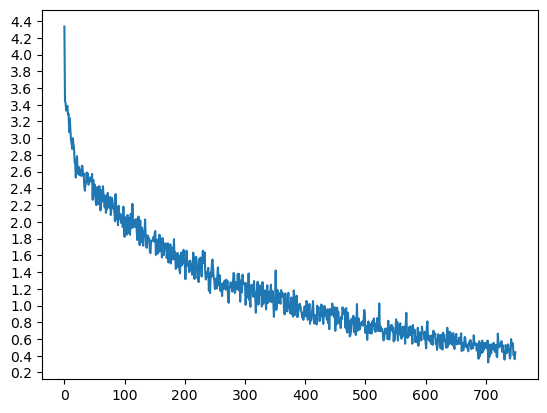

In [27]:
# DecoderRNN
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# time since - time to - avg loss
trainIters(encoder1, attn_decoder1, 75000, train_gru_attn, print_every=5000)

In [28]:
evaluateRandomly(encoder1, attn_decoder1, evaluate_gru_attn)

> il s en fourre plein les fouilles .
= he s raking it in .
< he s raking it . <EOS>

> j ecris pour exprimer mon insatisfaction .
= i am writing to express my dissatisfaction .
< i am writing to express my . . <EOS>

> il est dj .
= he is a dj .
< he is a dj . <EOS>

> quelle poisse j ai !
= i m so unlucky !
< i m so unlucky ! <EOS>

> t es plante .
= you re stuck .
< you re stuck . <EOS>

> je vous vire .
= i m letting you go .
< i m letting you . <EOS>

> nous sommes ici seuls .
= we re here alone .
< we re here alone . <EOS>

> c est toi qui m as entraine .
= you re the one who trained me .
< you re the one who trained me . <EOS>

> tu es aveugle par l amour .
= you are blinded by love .
< you are blinded by love . <EOS>

> je suis desole si je t ai effrayee .
= i m sorry if i frightened you .
< i m sorry if i frightened you . <EOS>



input = elle a cinq ans de moins que moi .
output = he is three years older than me . <EOS>


/tmp/ipykernel_973/1965647371.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_973/1965647371.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


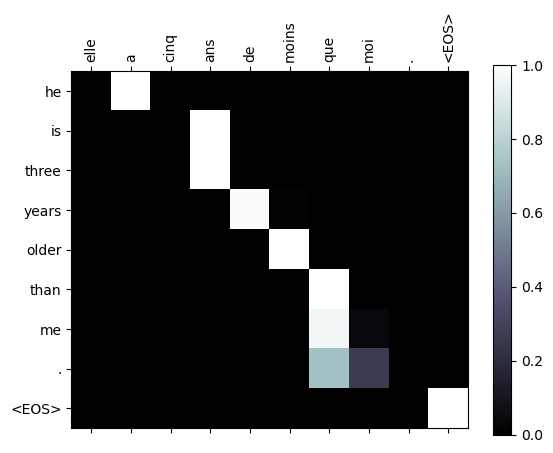

input = elle est trop petit .
output = he s too short . <EOS>


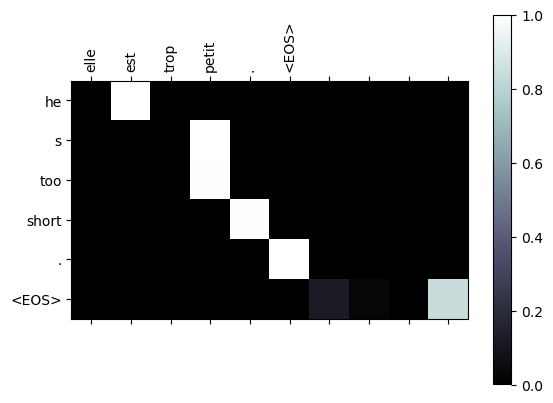

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


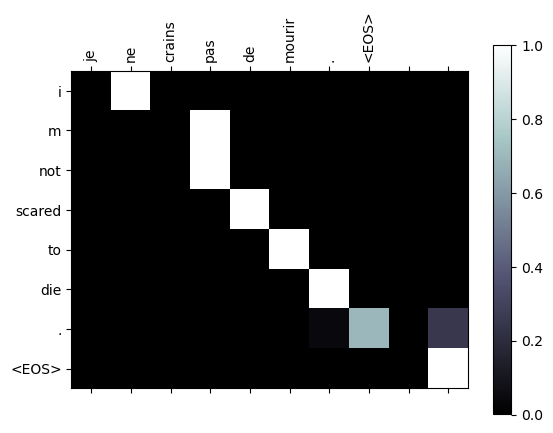

input = c est un jeune directeur plein de talent .
output = he s a talented young young . <EOS>


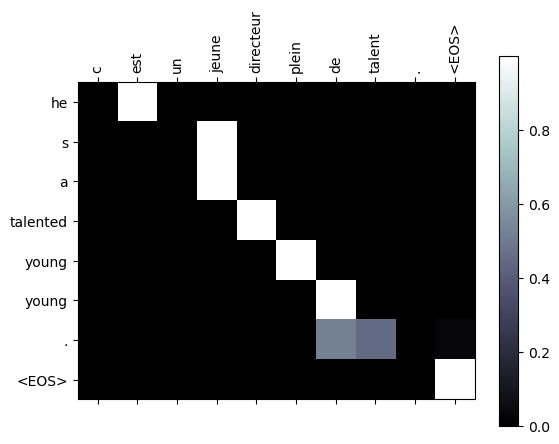

In [29]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoder1,
                         attn_decoder1, evaluate_gru_attn)

evaluateAndShowAttention("elle est trop petit .", encoder1, attn_decoder1,
                         evaluate_gru_attn)

evaluateAndShowAttention("je ne crains pas de mourir .", encoder1, attn_decoder1,
                         evaluate_gru_attn)

evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoder1,
                         attn_decoder1, evaluate_gru_attn)

**DecoderRNN**

2m 1s (- 28m 25s) (5000 6%) 2.8515
3m 58s (- 25m 51s) (10000 13%) 2.3066
6m 1s (- 24m 6s) (15000 20%) 2.0105
8m 4s (- 22m 11s) (20000 26%) 1.7582
10m 8s (- 20m 17s) (25000 33%) 1.5363
12m 11s (- 18m 17s) (30000 40%) 1.3793
14m 13s (- 16m 15s) (35000 46%) 1.1791
16m 17s (- 14m 15s) (40000 53%) 1.0477
18m 19s (- 12m 13s) (45000 60%) 0.9135
20m 25s (- 10m 12s) (50000 66%) 0.8251
22m 29s (- 8m 10s) (55000 73%) 0.7431
24m 35s (- 6m 8s) (60000 80%) 0.6661
26m 38s (- 4m 5s) (65000 86%) 0.5944
28m 42s (- 2m 3s) (70000 93%) 0.5254
30m 43s (- 0m 0s) (75000 100%) 0.4590


<Figure size 640x480 with 0 Axes>

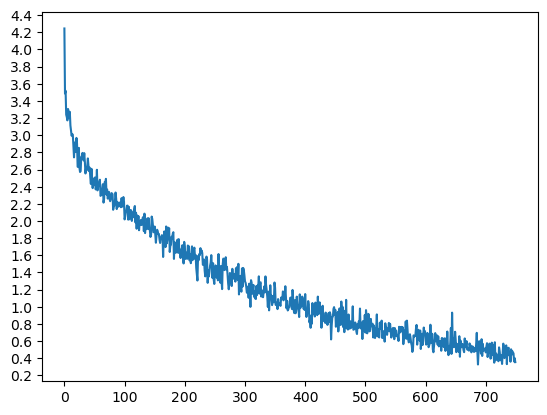

In [30]:
hidden_size = 256
encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder3, decoder2, 75000, train_gru, print_every=5000)

In [31]:
evaluateRandomly(encoder3, decoder2, evaluate_gru)

> je ne suis pas invincible .
= i m not invincible .
< i m not crazy . <EOS>

> il est l ami de tout le monde .
= he s everybody s friend .
< he s everybody s friend . <EOS>

> tu as vraiment beaucoup de chance .
= you re very fortunate .
< you re very fortunate . <EOS>

> vous etes a sec .
= you re out of booze .
< you re out of booze . <EOS>

> j en ai marre de ce temps humide .
= i am fed up with this wet weather .
< i am fed up with this wet weather . <EOS>

> nous avons tous faim .
= we re all hungry .
< we re all hungry . <EOS>

> ton nom m est familier .
= i am familiar with your name .
< i am familiar with your name . <EOS>

> nous attendons que tu sois parti .
= we re waiting for you to leave .
< we re waiting for you to leave . <EOS>

> je suis allergique aux chats .
= i m allergic to cats .
< i m allergic to cats . <EOS>

> je suis desolee je ne comprends pas .
= i m sorry i don t understand .
< i m sorry i don t understand . <EOS>



## Network architecture

<br>
<center style="font-size:13px;font-style:default;">Table 2. Comparing models by network architecture<b></b></center>

| Encoder |   Decoder  |   Loss  |   Training time  |   Parameters   |   Translation Quality  |
|------|--------|--------|--------|--------|--------|
|  EncoderRNN_LSTM   |    AttnDecoderRNN_LSTM   | 0.45 | 45 min |   Greater    |   9/10    |
|  EncoderRNN   |    AttnDecoderRNN   | 0.51 | 43 min |   Fewer    |   7/10    | 


As shown in Table 2, models with attention using GRU (`AttnDecoderRNN`), and LSTM (`AttnDecoderRNN_LSTM`) are also comparable. `AttnDecoderRNN_LSTM` ran for 45 mins, had a 0.45 loss, and got 90% of the 10 sample sentences correct. Whereas `AttnDecoderRNN` ran for 43 min, had a 0.51 loss, and got 70% of the 10 sample sentences correct.

Although `AttnDecoderRNN_LSTM` achieved higher accuracy with a lower loss, it required a slightly longer runtime. Again, this shows that the choice between the two models would depend on the specific priorities and trade-offs of the translation task at hand.

In this case, LSTM may have performed better than GRU due its capability to capture long-term dependencies in sequential data which is achieved by using a "memory cell". Moreover, LSTMs have larger model capacity which allows to potentially capture more complext patterns and relationships in data.

**AttnDecoder_LSTM**

2m 57s (- 41m 27s) (5000 6%) 2.9333
5m 53s (- 38m 17s) (10000 13%) 2.3339
8m 46s (- 35m 7s) (15000 20%) 1.9993
11m 43s (- 32m 15s) (20000 26%) 1.7449
14m 41s (- 29m 22s) (25000 33%) 1.5319
17m 40s (- 26m 30s) (30000 40%) 1.3506
20m 34s (- 23m 30s) (35000 46%) 1.1636
23m 32s (- 20m 35s) (40000 53%) 1.0293
26m 32s (- 17m 41s) (45000 60%) 0.9275
29m 27s (- 14m 43s) (50000 66%) 0.8032
32m 23s (- 11m 46s) (55000 73%) 0.7460
35m 21s (- 8m 50s) (60000 80%) 0.6625
38m 20s (- 5m 53s) (65000 86%) 0.5977
41m 17s (- 2m 56s) (70000 93%) 0.5209
44m 18s (- 0m 0s) (75000 100%) 0.4746


<Figure size 640x480 with 0 Axes>

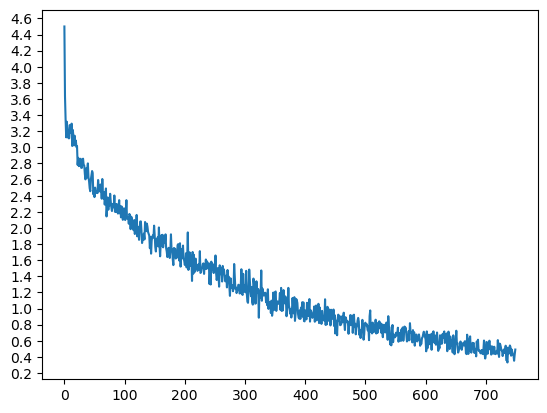

In [32]:
hidden_size = 256
cell_size = 256

encoder2 = EncoderRNN_LSTM(input_lang.n_words, hidden_size, cell_size).to(device)
attn_decoder2 = AttnDecoderRNN_LSTM(hidden_size, cell_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder2, 75000, train_lstm, print_every=5000)

In [33]:
evaluateRandomly(encoder2, attn_decoder2, evaluate_lstm)

> je ne vais pas partir avec toi .
= i m not leaving with you .
< i m not to you you . <EOS>

> ils sont loyaux envers leur maitre .
= they are loyal to their master .
< they are loyal to their master . <EOS>

> je suis nulle au tennis .
= i m terrible at tennis .
< i m at at tennis . <EOS>

> il est en train de manger .
= he is eating .
< he is eating now . <EOS>

> vous en avez termine .
= you re through .
< you re through . <EOS>

> il est non fumeur .
= he s a nonsmoker .
< he s a ill . <EOS>

> je retourne a la fac .
= i m going back to college .
< i m going back back college . <EOS>

> nous sommes prets a y aller .
= we re ready to go .
< we re ready to go . <EOS>

> je suis un peu ivre .
= i m a bit drunk .
< i m a bit drunk . <EOS>

> vous n allez jamais le croire .
= you re never going to believe this .
< you re never going to believe this . <EOS>



## Best model

The LSTM network was determined to be the best model among the three compared. This was then used to generate translations of 10 sample sentences in French, and compare with that of Google's.

In [35]:
# LSTM
best_encoder = encoder2
best_decoder = attn_decoder2

# Define sample french words and their Google translations
samples = ['je suis faineant .', 'nous ne sommes pas maries .', 
           'je suis plus que content .', 'je suis content de ma nouvelle veste .',
           'nous sommes a mi chemin de chez nous .', 'vous etes completement ignorante .',
           'je ne suis pas en colere .', 'vous etes le chef .',
           'je suis serieux .', 'c est un homme tres bien paye .']

google_translations = ["i am lazy", "we are not married",
                       "i'm more than happy", "am happy with my new jacket",
                       "we are halfway home", "you are completely ignorant",
                       "i'm not angry", "you are the boss", "i'm serious",
                       "he is a very well paid man"]

**5/10** of the samples were translated correctly by our best model. It's important to note that the other half are not completely off the expected translation. Some of them did not have the exact equivalent sentence but was able to capture the context or meaning behind the sentence. An example of this is how *vous etes completement ignorante* for "you are completely ignorant" was translated as "you re totally ignorant". On the other hand, some translations only has one word off the expected output. For example, "*je suis content de ma nouvelle veste*" for am happy with my new jacket was translated to "i m pleased with my new bathing" instead.

In general, the attention weights matrix follow the expected of having high values at the diagonal as this reflects the sequential recognition of each word in a sentence and indicates a well-trained data. However, there are still cases wherein the model was able to translate sentences correctly by skipping irrelevant words such as "*je suis plus que content*" for "i'm more than happy" and was indeed translated to "i m more than happy".

Google translation: i am lazy
input = je suis faineant .
output = i m lazy . <EOS>


/tmp/ipykernel_973/1965647371.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_973/1965647371.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


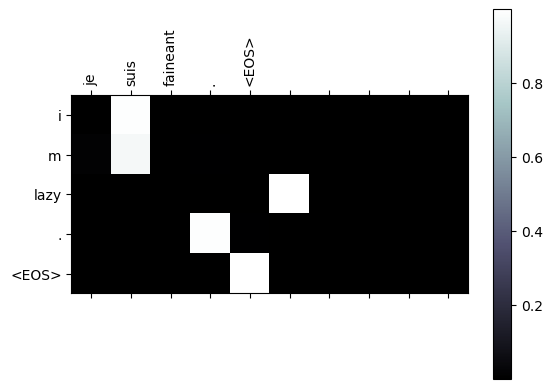

Google translation: we are not married
input = nous ne sommes pas maries .
output = we re not married . <EOS>


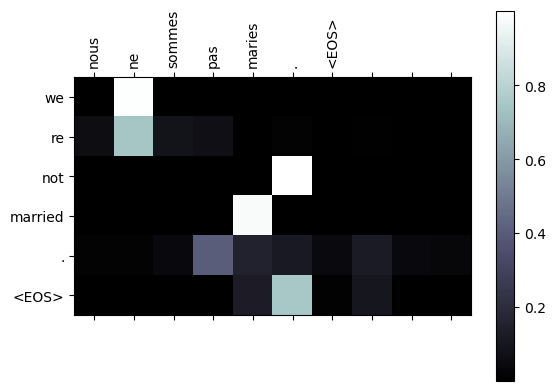

Google translation: i'm more than happy
input = je suis plus que content .
output = i m more than happy . <EOS>


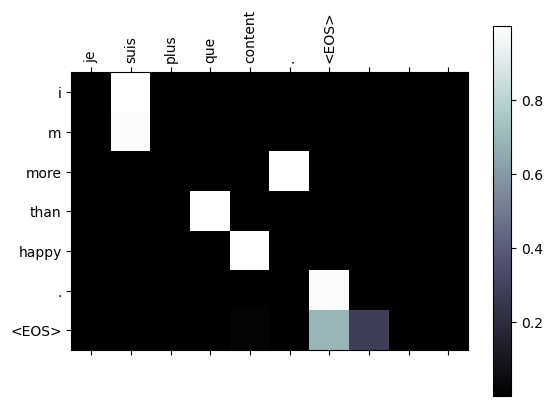

Google translation: am happy with my new jacket
input = je suis content de ma nouvelle veste .
output = i m pleased with my new bathing . <EOS>


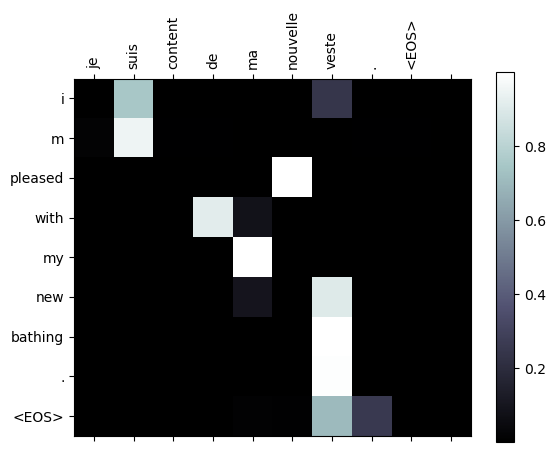

Google translation: we are halfway home
input = nous sommes a mi chemin de chez nous .
output = we re home home . <EOS>


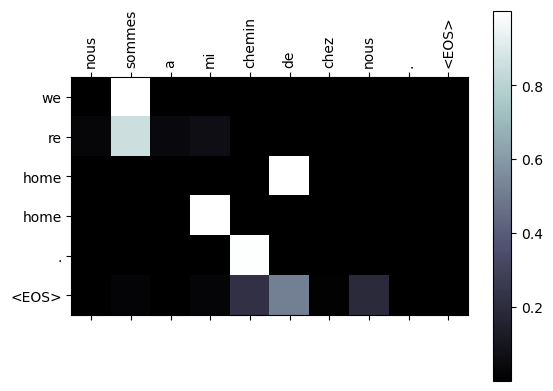

Google translation: you are completely ignorant
input = vous etes completement ignorante .
output = you re totally ignorant . <EOS>


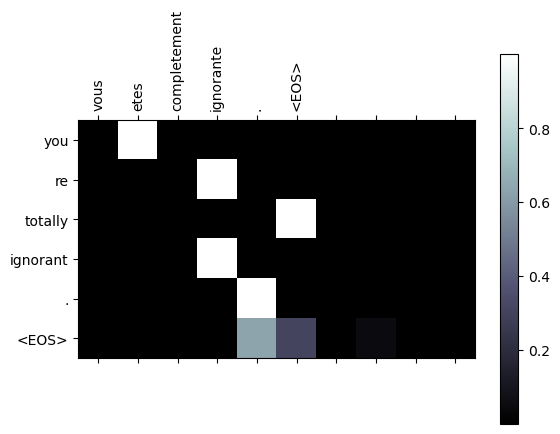

Google translation: i'm not angry
input = je ne suis pas en colere .
output = i m not angry . <EOS>


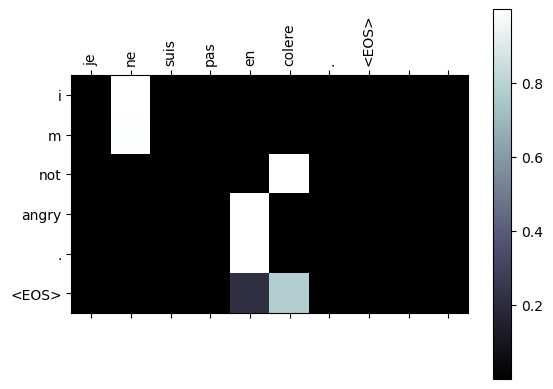

Google translation: you are the boss
input = vous etes le chef .
output = you re the leader . <EOS>


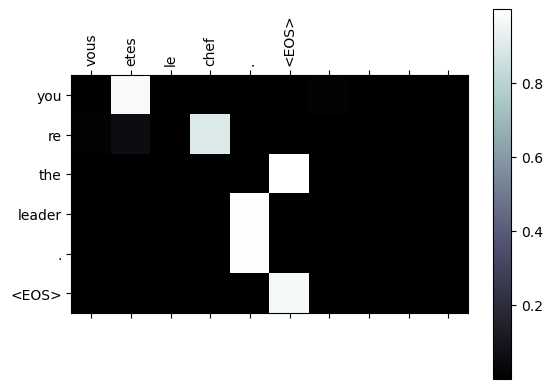

Google translation: i'm serious
input = je suis serieux .
output = i m serious serious <EOS>


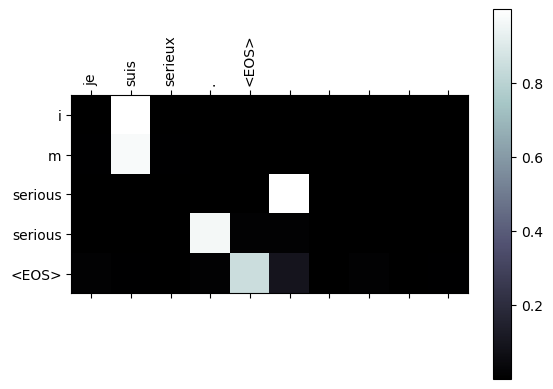

Google translation: he is a very well paid man
input = c est un homme tres bien paye .
output = he is a very fine man . <EOS>


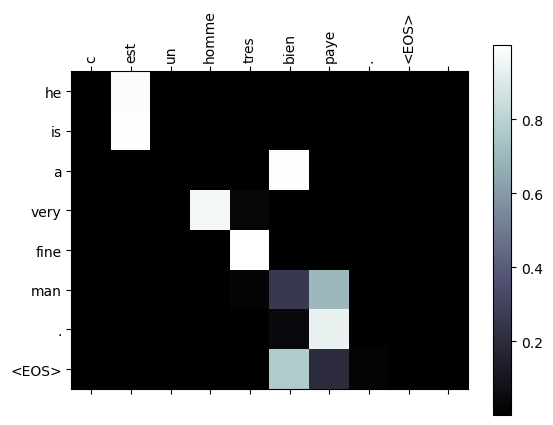

In [39]:
# Print the translation of our best model for comparison
for r in range(len(samples)):
#     print(f'French word: {samples[r]}')
    print(f'Google translation: {google_translations[r]}')
    evaluateAndShowAttention(samples[r], best_encoder, best_decoder, evaluate_lstm)

# IX. Generative AI Documentation

ChatGPT was used in this work for the following:

1. Proof read the explanations provided in the documentation.

2. Simplified explanations of complex topics (e.g., Machine Neural Network; Seq2Seq models)

3. Debug any issues encountered when writing the code for an LSTM Attention Decoder RNN.

4. Generate the docstrings per code block.


# X. References

[1] Bahdanau, D., Cho, K., & Bengio, Y. (2015). Neural Machine Translation by Jointly Learning to Align and Translate. In arXiv (Cornell University). Cornell University. https://arxiv.org/pdf/1409.0473

[2] Vinyals, O. (2015, June 19). A Neural Conversational Model. arXiv.org. https://arxiv.org/abs/1506.05869

[3] NLP From Scratch: Translation with a Sequence to Sequence Network and Attention — PyTorch Tutorials 2.0.1+cu117 documentation. (n.d.). https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

[5] GRU — PyTorch 2.0 documentation. (n.d.). https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

[6] Cho, K., Van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation. https://doi.org/10.3115/v1/d14-1179

[7] 
StatQuest with Josh Starmer. (2022, November 7). Long Short-Term Memory (LSTM), Clearly Explained [Video]. YouTube. https://www.youtube.com/watch?v=YCzL96nL7j0

[8] NLP From Scratch: Translation with a Sequence to Sequence Network and Attention — PyTorch Tutorials 2.0.1+cu117 documentation. (n.d.-b). https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

[9] LSTM — PyTorch 2.0 documentation. (n.d.). https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
